# EXPORT SALES DATA FOR ABC LTD

## Machine Learning Prediction of Future Export Sales for ABC Ltd

### Data information

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import geopandas as gpd
import joblib
import warnings

In [3]:
# Suppress warnings
warnings.filterwarnings("ignore")

In [4]:
#load data from source
#Data source from kraggle.com
#link: https://www.kaggle.com/datasets/susangrapes/fmcg-export-sales
df = pd.read_csv("C:/Users/Lenovo/Desktop/Udemy_Python/Project_1/ExportSales.csv")

In [5]:
#check df shape
df.shape

(7811, 9)

In [6]:
#check df
df.head(2)

,Product ID,Date,Category,Invoice Number,Product Code,Customer Code,Destination,Quantity,Total Price
0,2529604,4/28/2019,Category5,267,30011006,612,IRQ,750,3334.8225
1,2529605,4/29/2019,Category5,302,30011006,514,BHR,400,3032.8240


### DATA CLEANING AND MANIPULATION

In [7]:
# Check for missing values or zeros
if df.isnull().values.any() or (df == 0).any().any():
    missing_count = df.isnull().sum().sum()
    zero_count = (df == 0).sum().sum()
    total_cells = df.size
    missing_zero_count = missing_count + zero_count
    missing_zero_percentage = (missing_zero_count / total_cells) * 100

    print(f"Yes, there are {missing_count} missing values and {zero_count} zero values.")
    print(f"This represents {missing_zero_percentage:.2f}% of the entire dataset.")

    # Check if missing and zero percentage is less than 1%
    if missing_zero_percentage < 1.0:
        # If the missing and zero percentage is below 1%, drop rows
        df = df.replace(0, np.nan).dropna()
        print("Missing and zero values dropped.")
    else:
        print("Missing and zero percentage is greater than or equal to 1%, no rows dropped.")
else:
    print("No missing or zero values found.")


Yes, there are 110 missing values and 0 zero values.
This represents 0.16% of the entire dataset.
Missing and zero values dropped.


In [8]:
# Check for duplicates
duplicates = df[df.duplicated(subset=['Invoice Number', 'Quantity', 'Total Price', 'Product Code'], keep=False)]

if duplicates.empty:
    print("No duplicates found.")
else:
    total_duplicates = duplicates.shape[0]  # Count the total number of duplicate rows
    total_rows = df.shape[0]  # Total number of rows in the DataFrame
    percentage_duplicates = (total_duplicates / total_rows) * 100
    print(f"Total duplicates found: {total_duplicates}")
    print(f"Percentage of duplicates: {percentage_duplicates:.2f}%")

    # Drop duplicates based on subset of columns and keep first occurrence
    df.drop_duplicates(subset=['Invoice Number', 'Quantity', 'Total Price', 'Product Code'], keep='first', inplace=True)

    # Check for duplicates after removal
    duplicates_after_removal = df[df.duplicated(subset=['Invoice Number', 'Quantity', 'Total Price', 'Product Code'], keep=False)]

    if duplicates_after_removal.empty:
        print("Duplicates removed.")

Total duplicates found: 1382
Percentage of duplicates: 17.95%
Duplicates removed.


In [9]:
import pycountry_convert as pc

#Adding New Columns and removing Columns

# Add Actual Unit price
df['Price'] = (df['Total Price'] / df['Quantity']).round(2)

#Add Sales
# Calculate 'Total_Sales' by multiplying 'Quantity' and 'Average_Unit_Price'
df['Sales'] = df['Quantity'] * df['Price']

# Add Country Name
## Replace 'UAE' with 'ARE' in the 'Destination' column
df['Destination'] = df['Destination'].replace('UAE', 'ARE')

## Mapping between country codes and country names using pycountry library
def get_country_name(code):
    try:
        country = pycountry.countries.get(alpha_3=code)
        return country.name
    except AttributeError:
        return None

## Add a new column 'Country Name' based on the mapping
df['Country'] = df['Destination'].apply(get_country_name)

## Mapping to continent
def get_continent(row):
    cn_code = pc.country_name_to_country_alpha2(row['Country'], cn_name_format="default")
    conti = pc.country_alpha2_to_continent_code(cn_code)
    return conti
    
# Add a new column 'Continent' based on the alpha-3 country code
df['Continent'] = df.apply(get_continent, axis = 1)

#Mappin to Continent name
conti_names = {
    'AF': 'Africa',
    'AS': 'Asia',
    'EU': 'Europe',
    'NA': 'North America',
    'SA': 'South America',
    'OC': 'Oceania',
    'AN': 'Antarctica'
}

df['Continent'] = df['Continent'].map(conti_names)

# Convert 'Date' column to datetime format and extract components in one step
df['Date_Time'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date_Time'].dt.date
df['Month'] = df['Date_Time'].dt.month_name()
df['Year'] = df['Date_Time'].dt.year
df['Day_Name'] = df['Date_Time'].dt.day_name()
df['Quarter'] = df['Date_Time'].dt.to_period("Q")

#Remove Unused columns
Unused_column = ["Invoice Number", "Total Price"]
df = df.drop(columns=Unused_column)

#Rename column
df = df.rename(columns={'Destination': 'ISO_Code'})

In [10]:
# Check restructured df
df.head(2)

,Product ID,Date,Category,Product Code,Customer Code,ISO_Code,Quantity,Price,Sales,Country,Continent,Date_Time,Month,Year,Day_Name,Quarter
0,2529604,2019-04-28,Category5,30011006,612,IRQ,750,4.45,3337.5,Iraq,Asia,2019-04-28,April,2019,Sunday,2019Q2
1,2529605,2019-04-29,Category5,30011006,514,BHR,400,7.58,3032.0,Bahrain,Asia,2019-04-29,April,2019,Monday,2019Q2


In [11]:
# Recheck restructured df for missing values or zeros
if df.isnull().values.any() or (df == 0).any().any():
    missing_count = df.isnull().sum().sum()
    zero_count = (df == 0).sum().sum()
    total_cells = df.size
    missing_zero_count = missing_count + zero_count
    missing_zero_percentage = (missing_zero_count / total_cells) * 100

    print(f"Yes, there are {missing_count} missing values and {zero_count} zero values.")
    print(f"This represents {missing_zero_percentage:.2f}% of the entire dataset.")

    # Check if missing and zero percentage is less than 1%
    if missing_zero_percentage < 1.0:
        # If the missing and zero percentage is below 1%, drop rows
        df = df.replace(0, np.nan).dropna()
        print("Missing and zero values dropped.")
    else:
        print("Missing and zero percentage is greater than or equal to 1%, no rows dropped.")
else:
    print("No missing or zero values found.")


Yes, there are 0 missing values and 12 zero values.
This represents 0.01% of the entire dataset.
Missing and zero values dropped.


In [12]:
# check the shape of restructured df
df.shape

(7004, 16)

In [13]:
#check data type
df.dtypes

Product ID                int64
Date                     object
Category                 object
Product Code              int64
Customer Code             int64
ISO_Code                 object
Quantity                  int64
Price                   float64
Sales                   float64
Country                  object
Continent                object
Date_Time        datetime64[ns]
Month                    object
Year                      int64
Day_Name                 object
Quarter           period[Q-DEC]
dtype: object

In [14]:
# Check statistics of numerical columns
# List of columns to treat as categorical despite their numeric data type
categorical_columns = ['Product ID', 'Product Code', 'Customer Code', 'Year']

# Exclude categorical columns from descriptive statistics
numerical_columns = [col for col in df.columns if col not in categorical_columns]

# Calculate descriptive statistics for numerical columns
df_statistics = df[numerical_columns].describe()

# Print the statistics
print(df_statistics)

          Quantity        Price         Sales
count  7004.000000  7004.000000   7004.000000
mean    370.774129    13.705831   3254.358003
std     666.881585    11.280714   5369.442673
min       1.000000     1.240000      4.220000
25%      32.000000     6.650000    416.950000
50%     100.000000     9.520000   1057.000000
75%     400.000000    15.715000   3592.000000
max    5586.000000    72.520000  77525.000000


In [15]:
# Define and store the FuncFormatter for y axis value and use when needed

from matplotlib.ticker import FuncFormatter

def format_func(value, tick_number):
    if value >= 1_000_000:
        value /= 1_000_000
        return f'${value:.0f}M'
    elif value >= 1_000:
        value /= 1_000
        return f'${value:.0f}K'
    else:
        return f'${value:.0f}'


In [16]:
#Create new datframe for Predictive Modelling
#Include and Transform categorical data to numeric

#Aggregate using Date_Time

# Create rf_df DataFrame from df
rf_df_columns = [
    'No of Product(s)',
    'No of Country(s)',
    'Total_Quantity',
    'Total_Sales',
    'Total_Price',
    'No of Distributor(s)',
    'Date_Time'
]
rf_df = pd.DataFrame(columns=rf_df_columns)

# Populate rf_df DataFrame
rf_df['Date_Time'] = df['Date_Time'].unique()
rf_df['No of Product(s)'] = df.groupby('Date_Time')['Product Code'].nunique().loc[rf_df['Date_Time']].values
rf_df['No of Country(s)'] = df.groupby('Date_Time')['Country'].nunique().loc[rf_df['Date_Time']].values
rf_df['Total_Quantity'] = df.groupby('Date_Time')['Quantity'].sum().loc[rf_df['Date_Time']].values
rf_df['Total_Price'] = df.groupby('Date_Time')['Price'].sum().loc[rf_df['Date_Time']].values
rf_df['No of Distributor(s)'] = df.groupby('Date_Time')['Customer Code'].nunique().loc[rf_df['Date_Time']].values
rf_df['Total_Sales'] = df.assign(Sales_Amount=df['Quantity'] * df['Price']).groupby('Date_Time')['Sales_Amount'].sum().loc[rf_df['Date_Time']].values

In [17]:
#check new predictve modelling df
rf_df.head(2)

,No of Product(s),No of Country(s),Total_Quantity,Total_Sales,Total_Price,No of Distributor(s),Date_Time
0,7,1,7450,34008.5,69.21,1,2019-04-28
1,15,1,4550,31679.5,116.31,1,2019-04-29


In [18]:
rf_df.describe()

,No of Product(s),No of Country(s),Total_Quantity,Total_Sales,Total_Price,No of Distributor(s)
count,340.000000,340.000000,340.000000,340.000000,340.000000,340.000000
mean,16.314706,1.488235,7637.947059,67039.774853,282.340118,1.911765
std,16.158080,0.788847,7359.930302,70132.682221,375.154279,1.284527
min,1.000000,1.000000,40.000000,330.000000,2.200000,1.000000
25%,4.000000,1.000000,2918.750000,17382.225000,32.252500,1.000000
50%,10.000000,1.000000,5190.000000,40640.240000,132.750000,1.000000
75%,25.000000,2.000000,10769.000000,96386.445000,372.940000,2.000000
max,80.000000,5.000000,50782.000000,516553.220000,2223.790000,8.000000


### DATA EXPLORATION

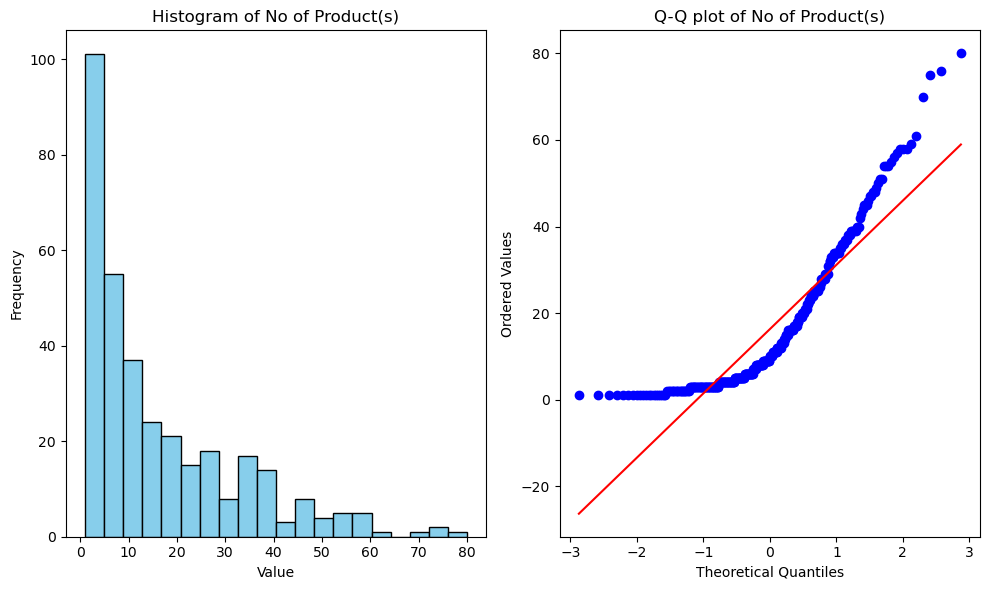

Kolmogorov-Smirnov Test for No of Product(s):
KS Statistic: 0.9184263386400561
P-value: 0.0
The Variable does not follow a normal distribution.


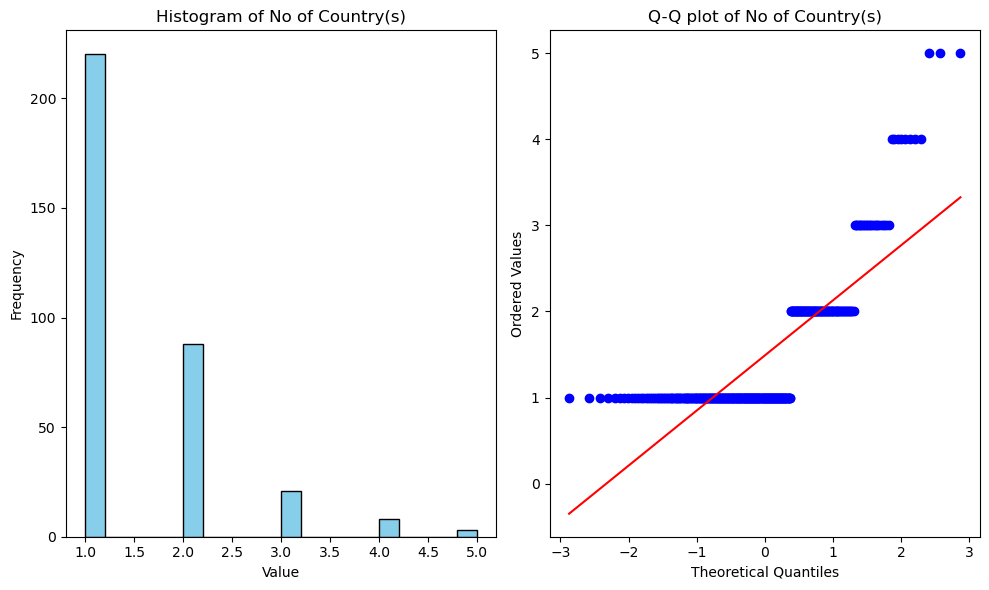

Kolmogorov-Smirnov Test for No of Country(s):
KS Statistic: 0.8413447460685429
P-value: 4.926738087790258e-271
The Variable does not follow a normal distribution.


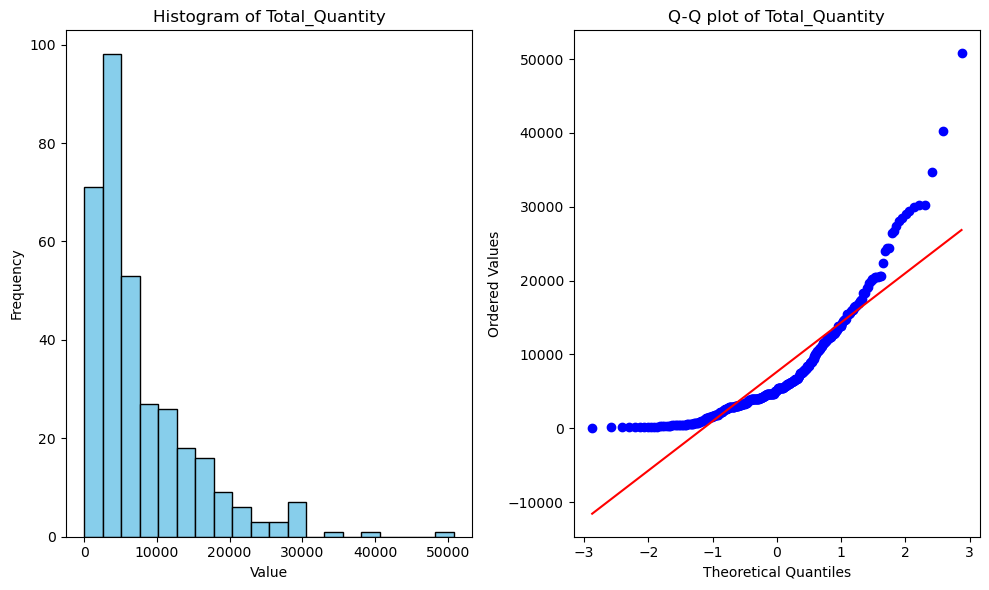

Kolmogorov-Smirnov Test for Total_Quantity:
KS Statistic: 1.0
P-value: 0.0
The Variable does not follow a normal distribution.


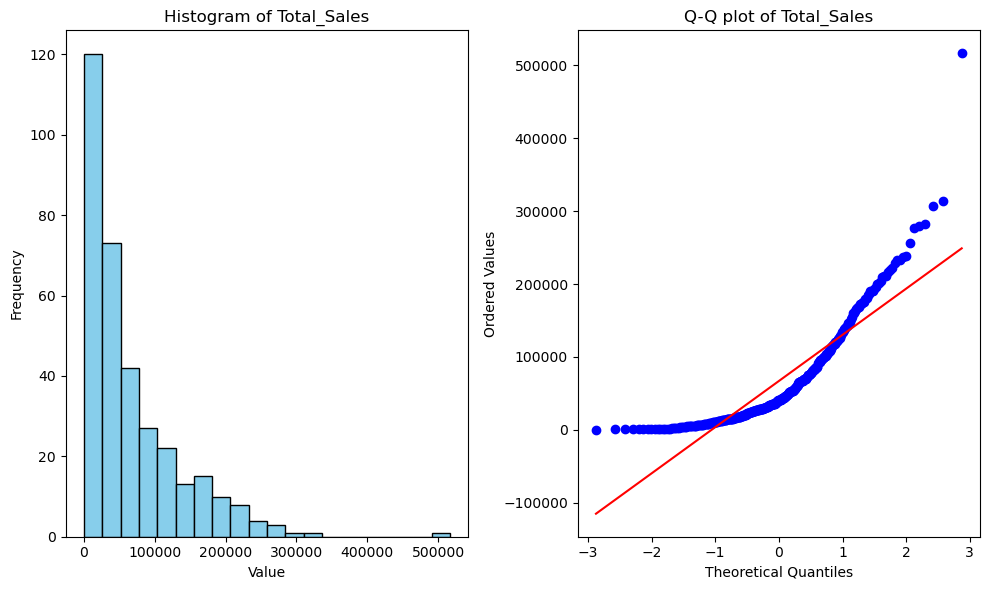

Kolmogorov-Smirnov Test for Total_Sales:
KS Statistic: 1.0
P-value: 0.0
The Variable does not follow a normal distribution.


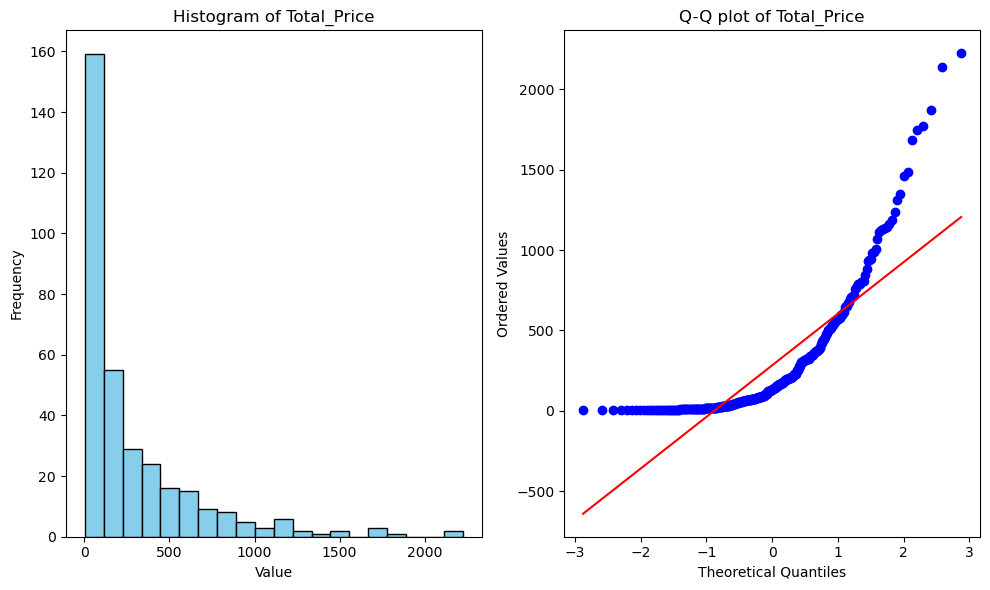

Kolmogorov-Smirnov Test for Total_Price:
KS Statistic: 0.9960238205546089
P-value: 0.0
The Variable does not follow a normal distribution.


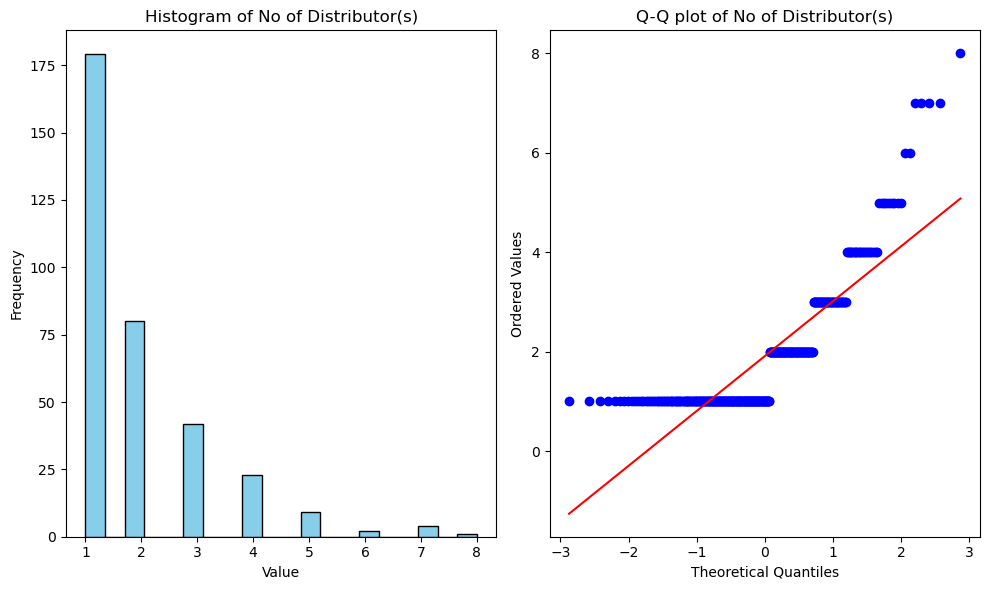

Kolmogorov-Smirnov Test for No of Distributor(s):
KS Statistic: 0.8413447460685429
P-value: 4.926738087790258e-271
The Variable does not follow a normal distribution.


In [19]:
# Check data for normality with Histogram, Q-Q plot and Kolmogorov-Smirnov test to detrmine choice of model

import scipy.stats as stats

#  columns to check for normality
columns_to_check = ['No of Product(s)', 'No of Country(s)', 'Total_Quantity', 'Total_Sales', 'Total_Price', 'No of Distributor(s)']

# plot histogram and Q-Q plot
def plot_distribution(column_data, column_name):
    # Plot histogram
    plt.figure(figsize=(10, 6)) 
    plt.subplot(1, 2, 1)
    plt.hist(column_data, bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column_name}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Plot Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(column_data, dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {column_name}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Ordered Values')
    plt.tight_layout()
    plt.show()

# perform Kolmogorov-Smirnov test
def perform_ks_test(column_data, column_name):
    ks_statistic, p_value = stats.kstest(column_data, 'norm')
    print(f"Kolmogorov-Smirnov Test for {column_name}:")
    print(f"KS Statistic: {ks_statistic}")
    print(f"P-value: {p_value}")
    if p_value < 0.05:
        print("The Variable does not follow a normal distribution.")
    else:
        print("The Variable follows a normal distribution.")

# Plot distribution and perform KS test for each column
for column in columns_to_check:
    plot_distribution(rf_df[column], column)
    perform_ks_test(rf_df[column], column)

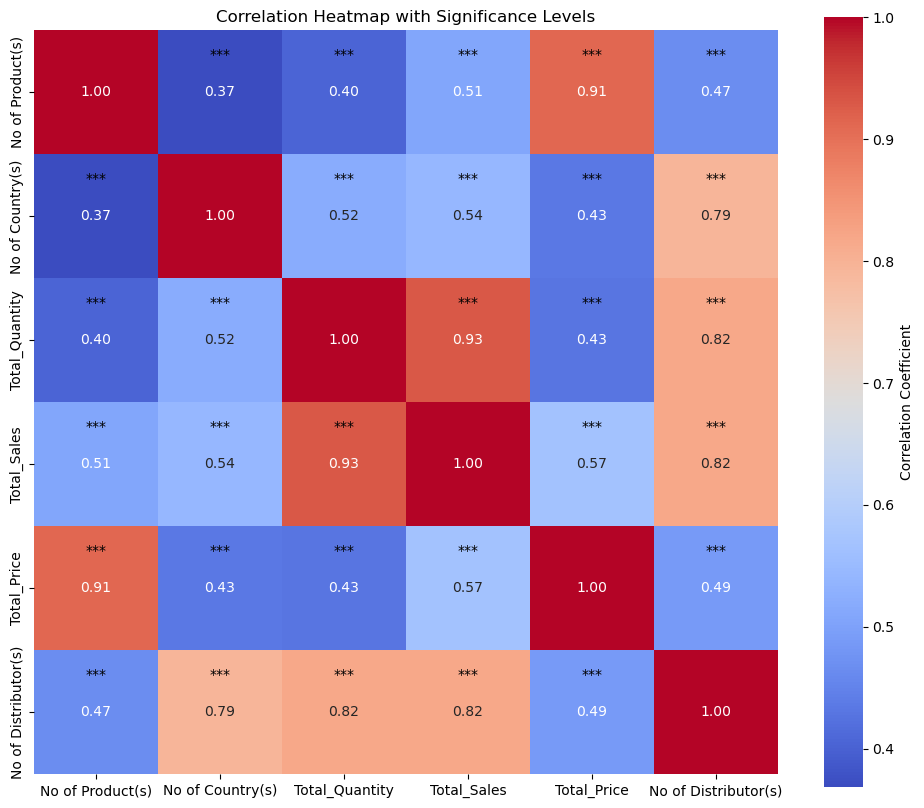

In [229]:
# Check for relationship/correlation between variables

from scipy.stats import pearsonr

# Calculate correlation matrix excluding the Date_Time column
correlation_matrix = rf_df.drop(columns=['Date_Time']).corr()

# Calculate p-values
p_values = pd.DataFrame()  # Create an empty DataFrame to store p-values
for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.columns:
        if col1 != col2:
            corr, p_value = pearsonr(rf_df[col1], rf_df[col2])
            p_values.loc[col1, col2] = p_value

# Plot heatmap with significance levels
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, 
            cbar_kws={'label': 'Correlation Coefficient'})

# Annotate the heatmap with significance levels
for i, (row_name, row) in enumerate(correlation_matrix.iterrows()):
    for j, corr_value in enumerate(row):
        if i != j:  # Exclude diagonal elements
            p_value = p_values.loc[row_name, correlation_matrix.columns[j]]
            if p_value < 0.01:
                plt.text(j + 0.5, i + 0.2, '***', ha='center', va='center', fontsize=10, color='black')
            elif p_value < 0.05:
                plt.text(j + 0.5, i + 0.2, '**', ha='center', va='center', fontsize=10, color='black')
            elif p_value < 0.1:
                plt.text(j + 0.5, i + 0.2, '*', ha='center', va='center', fontsize=10, color='black')

plt.title('Correlation Heatmap with Significance Levels')
plt.savefig('Correlation Heatmap with Significance Levels.jpeg', dpi=300)
plt.show()


## PREDICTIVE MODELLING 

## Modelling the Historical/Actual Export Sales

### Random Forest Modelling

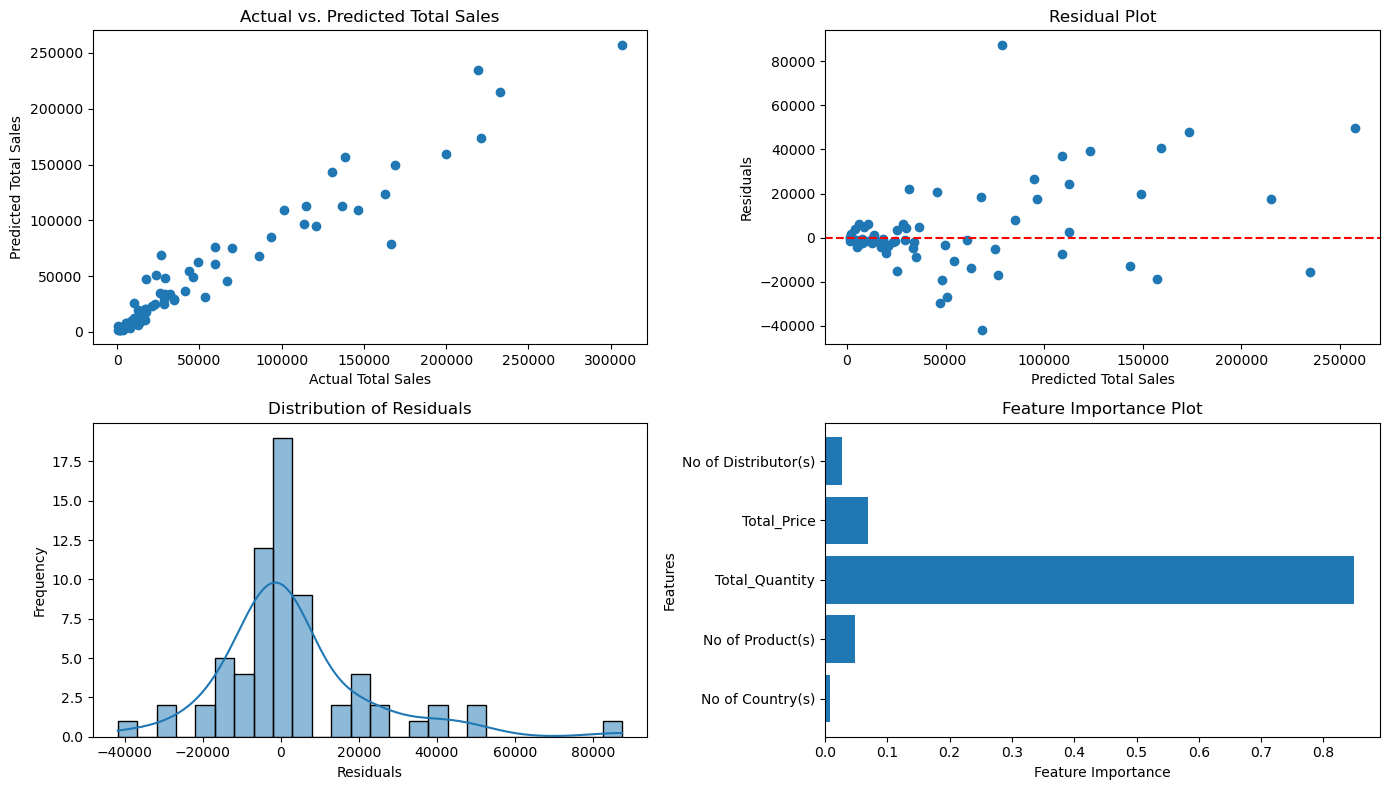

Mean Absolute Error (MAE): 12106.821033823522
Root Mean Squared Error (RMSE): 19742.079700825456
R-squared (R2): 0.9177154110749687
Adjusted R-squared: 0.9110795571294017


In [230]:
#Train and fit Random forest model on the Histotical dataset

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Features and target variable
X = rf_df[['No of Country(s)', 'No of Product(s)', 'Total_Quantity', 'Total_Price', 'No of Distributor(s)' ]]
y = rf_df['Total_Sales']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Adjusted R-squared calculation
n = len(X_test)
p = X_test.shape[1]
adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Actual vs. Predicted Plot
axes[0, 0].scatter(y_test, y_pred)
axes[0, 0].set_xlabel('Actual Total Sales')
axes[0, 0].set_ylabel('Predicted Total Sales')
axes[0, 0].set_title('Actual vs. Predicted Total Sales')

# Residual Plot
residuals = y_test - y_pred
axes[0, 1].scatter(y_pred, residuals)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_xlabel('Predicted Total Sales')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot')

# Distribution of Residuals
sns.histplot(residuals, kde=True, ax=axes[1, 0])
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Residuals')

# Feature Importance Plot
feature_importances = rf_model.feature_importances_
feature_names = X.columns
axes[1, 1].barh(feature_names, feature_importances)
axes[1, 1].set_xlabel('Feature Importance')
axes[1, 1].set_ylabel('Features')
axes[1, 1].set_title('Feature Importance Plot')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')
print(f'Adjusted R-squared: {adj_r2}')


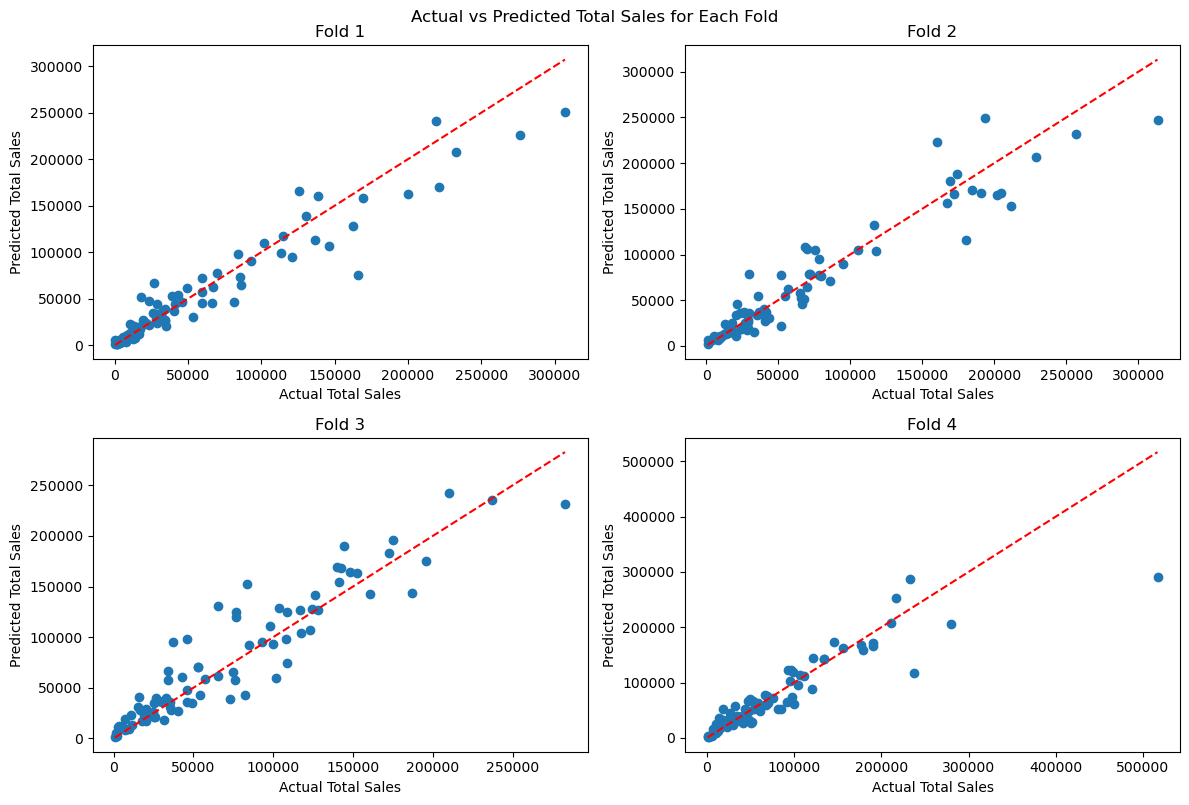

Fold 1:
MAE: 12274.411576470584
R-squared: 0.9126334293642081

Fold 2:
MAE: 13321.414694117651
R-squared: 0.910468089934285

Fold 3:
MAE: 16095.089914117654
R-squared: 0.8629256182669895

Fold 4:
MAE: 16750.849149411762
R-squared: 0.8258033560228042

Average MAE: 14610.441333529414
Average R-squared: 0.8779576233970717


In [231]:
# Perform 4 fold Cross Validation

# 4 splits K fold cross-validation

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold

# Features and target variable
X = rf_df[['No of Country(s)', 'No of Product(s)', 'Total_Quantity', 'Total_Price', 'No of Distributor(s)']]
y = rf_df['Total_Sales']

# Initialize KFold cross-validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Initialize lists to store evaluation metrics
mae_list = []
r2_list = []

# Perform cross-validation
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Instantiate the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = rf_model.predict(X_test)
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Append metrics to lists
    mae_list.append(mae)
    r2_list.append(r2)
    
    # Plot Actual vs Predicted for each fold with a line between them
    ax = axes[fold // 2, fold % 2]
    ax.scatter(y_test, y_pred, label='Actual vs Predicted')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Line')
    ax.set_xlabel('Actual Total Sales')
    ax.set_ylabel('Predicted Total Sales')
    ax.set_title(f'Fold {fold+1}')
    plt.tight_layout()

plt.suptitle('Actual vs Predicted Total Sales for Each Fold', y=1)
plt.show()
    
# Print evaluation metrics for each fold
for i in range(len(mae_list)):
    print(f"Fold {i+1}:")
    print(f"MAE: {mae_list[i]}")
    print(f"R-squared: {r2_list[i]}")
    print()

# Calculate and print average metrics
average_mae = np.mean(mae_list)
average_r2 = np.mean(r2_list)
print(f"Average MAE: {average_mae}")
print(f"Average R-squared: {average_r2}")


Mean Absolute Error (MAE): 5514.847590588237
R-squared (R2): 0.9797961955978526


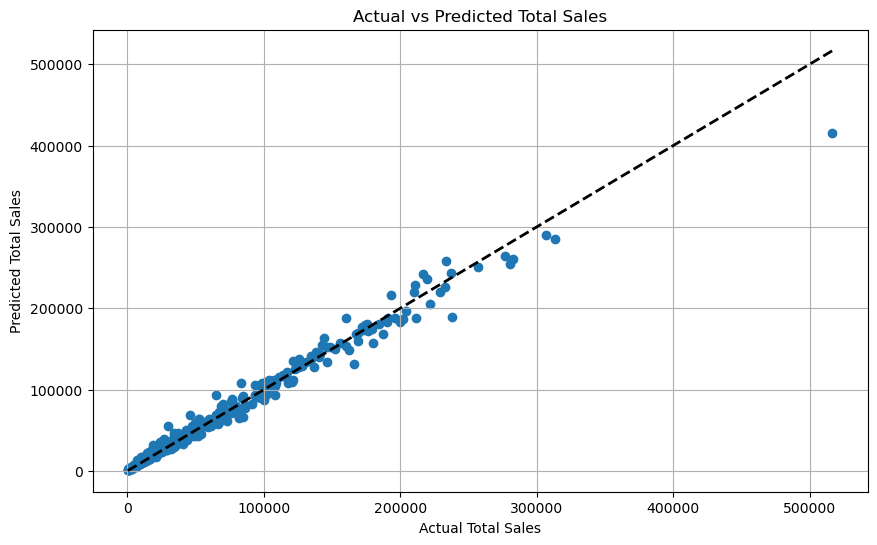

In [262]:
# fit the model to the entire dataset

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Features and target variable
X = rf_df[['No of Product(s)', 'No of Country(s)', 'Total_Quantity', 'Total_Price', 'No of Distributor(s)']]
y = rf_df['Total_Sales']

# Instantiate the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the entire dataset
rf_model.fit(X, y)

# Save the trained Random Forest model as 'RF_Model_Save.pkl'
joblib.dump(rf_model, 'RF_Model_Save.pkl')

# Make predictions on the entire dataset
y_pred = rf_model.predict(X)

# Create a DataFrame with Date_Time, actual Total_sales, and predicted Total_sales
random_df = pd.DataFrame({
    'Actual_Total_Sales': y.values,
    'Predicted_Total_Sales': y_pred,
    'Date_Time': rf_df['Date_Time']  # Assuming 'Date_Time' column exists in rf_df
})
# Set 'Date_Time' as index
random_df.set_index('Date_Time', inplace=True)

# Calculate evaluation metrics
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred)
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)  # Plot y = x line
plt.xlabel('Actual Total Sales')
plt.ylabel('Predicted Total Sales')
plt.title('Actual vs Predicted Total Sales')
plt.grid(True)
plt.show()

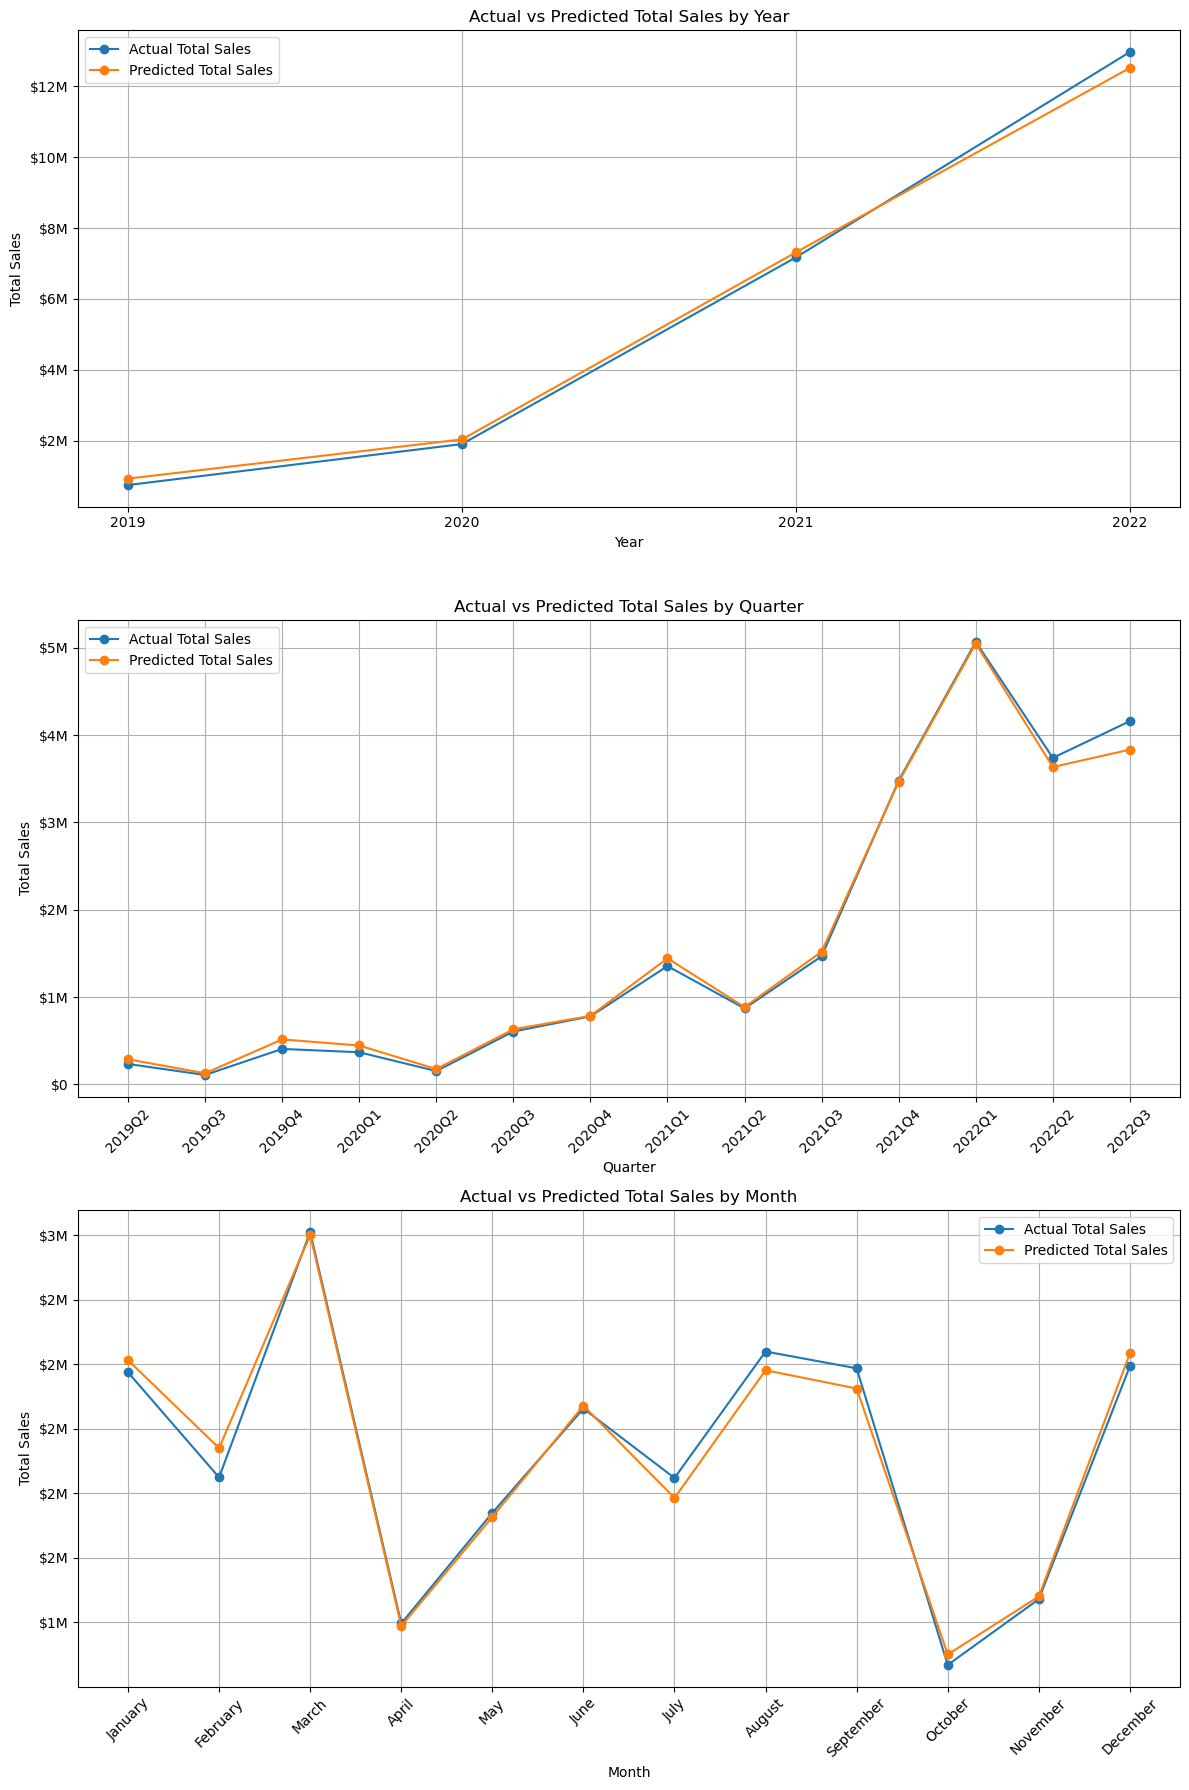

In [168]:
#Visualize the Actual and Predicted for the entire Data set

import matplotlib.ticker as ticker
import scipy.stats as stats

# Create a copy of the DataFrame
random_df_copy = random_df.copy()

# Extract year from the 'Date_Time' column
random_df_copy['Year'] = random_df_copy.index.year.astype(int)

# Group by year and calculate the sum of 'Actual_Total_Sales' and 'Predicted_Total_Sales'
yearly_sales = random_df_copy.groupby('Year').sum()

# Extract quarter and year from the 'Date_Time' column and map to quarter names in 'YYYYQn' format
random_df_copy['Quarter'] = random_df_copy.index.to_period('Q').strftime('%YQ%q')

# Group by quarter and calculate the sum of 'Actual_Total_Sales' and 'Predicted_Total_Sales'
quarterly_sales = random_df_copy.groupby('Quarter').sum()

# Extract month from the 'Date_Time' column
random_df_copy['Month'] = random_df_copy.index.month_name()

# Group by month and calculate the sum of 'Actual_Total_Sales' and 'Predicted_Total_Sales'
monthly_sales = random_df_copy.groupby('Month').sum()

# Sort months in chronological order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_sales = monthly_sales.reindex(months_order)

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(12, 18))


# Plot Yearly Sales
axs[0].plot(yearly_sales.index, yearly_sales['Actual_Total_Sales'], marker='o', label='Actual Total Sales')
axs[0].plot(yearly_sales.index, yearly_sales['Predicted_Total_Sales'], marker='o', label='Predicted Total Sales')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Total Sales')
axs[0].set_title('Actual vs Predicted Total Sales by Year')
axs[0].set_xticks(yearly_sales.index)
axs[0].legend()
axs[0].grid(True)
axs[0].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# Plot Quarterly Sales
axs[1].plot(quarterly_sales.index.astype(str), quarterly_sales['Actual_Total_Sales'], marker='o', label='Actual Total Sales')
axs[1].plot(quarterly_sales.index.astype(str), quarterly_sales['Predicted_Total_Sales'], marker='o', label='Predicted Total Sales')
axs[1].set_xlabel('Quarter')
axs[1].set_ylabel('Total Sales')
axs[1].set_title('Actual vs Predicted Total Sales by Quarter')
axs[1].set_xticks(range(len(quarterly_sales)))
axs[1].set_xticklabels(quarterly_sales.index.astype(str), rotation=45)
axs[1].legend()
axs[1].grid(True)
axs[1].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# Plot Monthly Sales
axs[2].plot(monthly_sales.index, monthly_sales['Actual_Total_Sales'], marker='o', label='Actual Total Sales')
axs[2].plot(monthly_sales.index, monthly_sales['Predicted_Total_Sales'], marker='o', label='Predicted Total Sales')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Total Sales')
axs[2].set_title('Actual vs Predicted Total Sales by Month')
axs[2].set_xticks(range(len(months_order)))
axs[2].set_xticklabels(months_order, rotation=45)
axs[2].legend()
axs[2].grid(True)
axs[2].yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# Adjust layout
plt.tight_layout()
plt.show()


## Forecasting Export Sales from Oct. 2022 - Dec. 2025

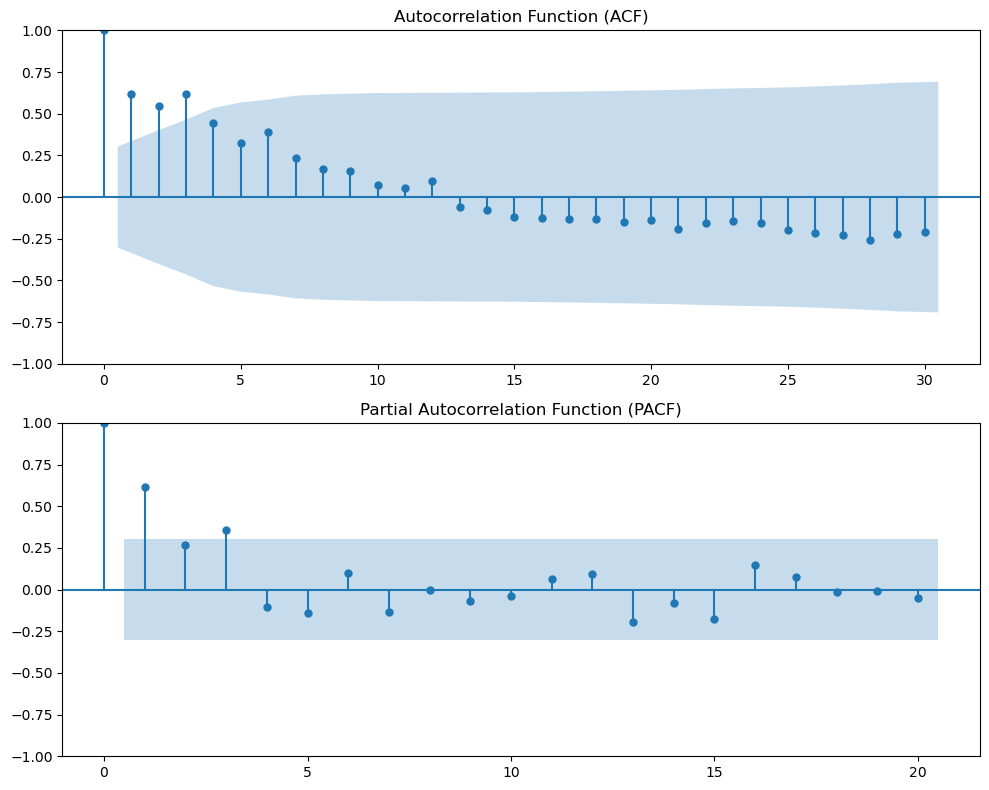

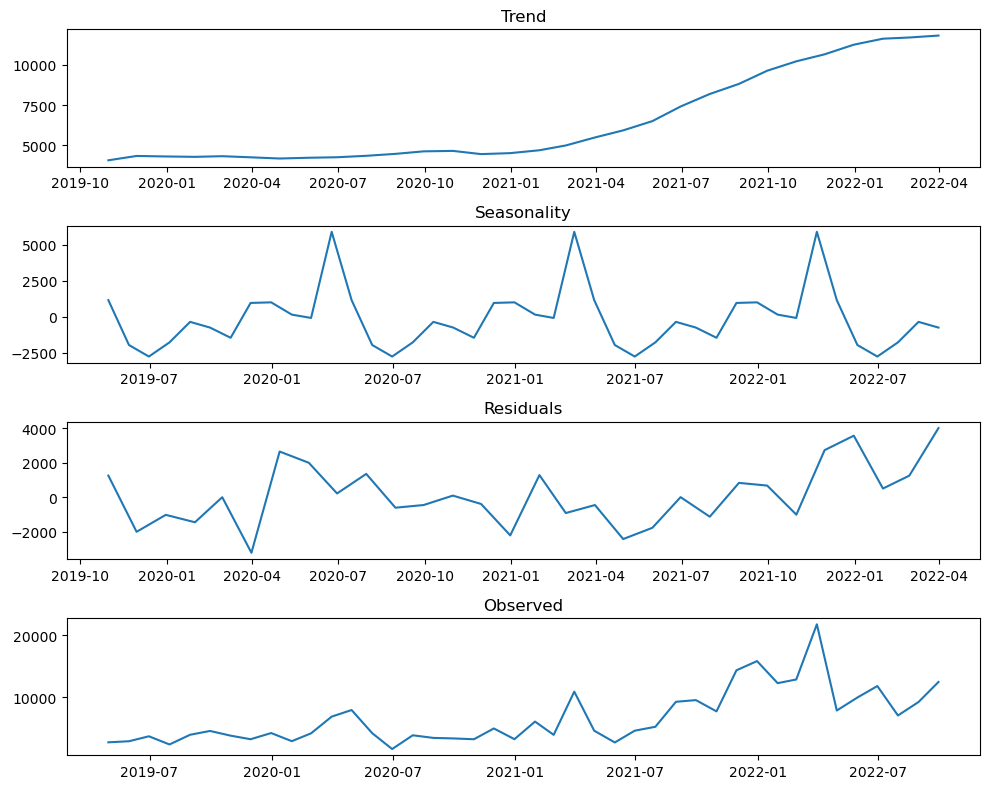

Best SARIMA order: (1, 1, 1)
Best seasonal SARIMA order: (2, 2, 2, 12)


In [235]:
#Run SARIMA Model to get Best order for prediction

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Create a copy of rf_df
rf_df_copy = rf_df.copy()

# Ensure 'Date_Time' column is in datetime format
rf_df_copy['Date_Time'] = pd.to_datetime(rf_df_copy['Date_Time'])

# Sort the DataFrame by 'Date_Time'
rf_df_copy.sort_values(by='Date_Time', inplace=True)

# Set 'Date_Time' as the index
rf_df_copy.set_index('Date_Time', inplace=True)

# Resample the data to a monthly frequency
rf_df_monthly = rf_df_copy['Total_Quantity'].resample('M').mean().dropna()

# Perform autocorrelation and partial autocorrelation analysis
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot autocorrelation function (ACF)
plot_acf(rf_df_monthly, lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# Plot partial autocorrelation function (PACF)
plot_pacf(rf_df_monthly, lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Perform seasonal decomposition
decomposition = seasonal_decompose(rf_df_monthly, model='additive')

# Plot the decomposed components
fig, ax = plt.subplots(4, 1, figsize=(10, 8))
ax[0].plot(decomposition.trend)
ax[0].set_title('Trend')
ax[1].plot(decomposition.seasonal)
ax[1].set_title('Seasonality')
ax[2].plot(decomposition.resid)
ax[2].set_title('Residuals')
ax[3].plot(decomposition.observed)
ax[3].set_title('Observed')
plt.tight_layout()
plt.show()

# Grid search for SARIMA orders
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[1], x[1], x[2], 12) for x in pdq]  # Assuming monthly seasonality

best_aic = float('inf')
best_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(rf_df_monthly, order=param, seasonal_order=param_seasonal)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = param_seasonal
                best_results = results  # Store the best results
        except:
            continue

print('Best SARIMA order:', best_order)
print('Best seasonal SARIMA order:', best_seasonal_order)


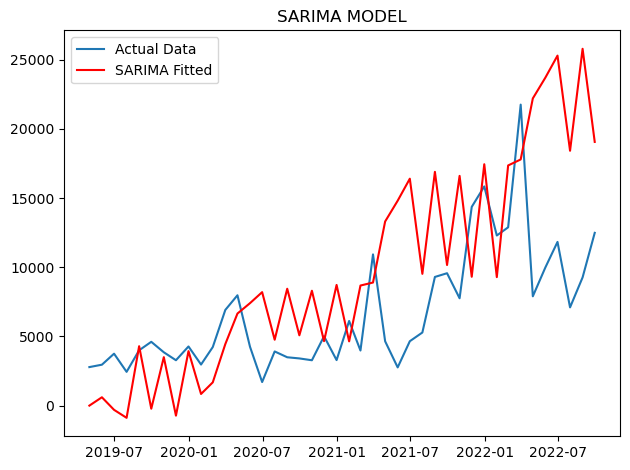

In [236]:
# Plot SARIMA results
sarima_model = SARIMAX(rf_df_monthly, order=best_order, seasonal_order=best_seasonal_order)
sarima_results = sarima_model.fit()
plt.plot(rf_df_monthly.index, rf_df_monthly, label='Actual Data')
plt.plot(rf_df_monthly.index, sarima_results.fittedvalues, label='SARIMA Fitted', color='red')
plt.title('SARIMA MODEL')
plt.legend()

plt.tight_layout()

# Save the figure
plt.savefig('sarimaa_analysis.png')
plt.show()

In [237]:
# Print summary of the SARIMAX model
print(best_results.summary())

                                        SARIMAX Results                                        
Dep. Variable:                          Total_Quantity   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(2, 2, [1, 2], 12)   Log Likelihood                   0.000
Date:                                 Fri, 15 Mar 2024   AIC                             14.000
Time:                                         18:28:04   BIC                             19.832
Sample:                                     04-30-2019   HQIC                            14.580
                                          - 09-30-2022                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8950      0.002   -474.919      0.000      -0.899      -0

In [238]:
#Forecast the future values of variables from October 2022 to December 2025 using best fit order

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Aggregate data to monthly level
rf_df_monthly = rf_df.resample('M', on='Date_Time').sum()

# Define variables
variables = ['No of Product(s)', 'No of Country(s)', 'Total_Quantity', 'Total_Price', 'No of Distributor(s)']

# Dictionary to store forecasted values for each variable
forecast_data = {}

# Fit SARIMA models and make forecasts for each variable
for variable in variables:
    # Fit SARIMA model
    model = SARIMAX(rf_df_monthly[variable], order=(1, 1, 1), seasonal_order=(2, 2, 2, 12))
    sarima_model = model.fit()
    
    # Forecast for October 2022 to December 2025
    forecast = sarima_model.forecast(steps=38).round(2) if variable == 'Total_Price' else sarima_model.forecast(steps=38).round().astype(int)
    
    # Store forecasted values in dictionary
    forecast_data[f'{variable}'] = forecast

# Create DataFrame from forecasted values
forecast_df = pd.DataFrame(forecast_data)

# Create date range for the forecast period
forecast_dates = pd.date_range(start='2022-10-01', periods=38, freq='M')

# Add Date_Time column to the DataFrame
forecast_df['Date_Time'] = forecast_dates

# Set Date_Time as index
forecast_df.set_index('Date_Time', inplace=True)

In [239]:
#check Forecasted data
forecast_df.head()

,No of Product(s),No of Country(s),Total_Quantity,Total_Price,No of Distributor(s)
Date_Time,,,,,
2022-10-31,100,21,61437,7272.21,30
2022-11-30,265,32,186226,2396.42,61
2022-12-31,201,43,324716,6772.03,82
2023-01-31,304,51,329764,5814.73,91
2023-02-28,167,29,269192,7159.25,74


In [240]:
#Actual data after resampling to monthly frequency for SARIMA model
rf_df_monthly.head()

,No of Product(s),No of Country(s),Total_Quantity,Total_Sales,Total_Price,No of Distributor(s)
Date_Time,,,,,,
2019-04-30,43,6,16700,93442.03,496.05,6
2019-05-31,67,10,29565,99919.30,546.33,10
2019-06-30,26,5,11255,40380.10,198.84,5
2019-07-31,40,6,14639,50259.53,495.00,6
2019-08-31,15,4,15993,44352.59,101.82,4


In [270]:
#Fit Random Forest Model to predict Total Sales from October 2022 - December 2025
from sklearn.ensemble import RandomForestRegressor

# Create a copy of rf_df_monthly and forecast_df
rf_df_monthly_copy = rf_df_monthly.copy()
forecast_df_copy = forecast_df.copy()

# Extract the features and target variable from rf_df_monthly_copy
X_train = rf_df_monthly_copy.drop(columns=['Total_Sales'])
y_train = rf_df_monthly_copy['Total_Sales']

# Initialize and train the Random Forest regressor
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

# Extract features from forecast_df
X_forecast = forecast_df_copy  

# Make predictions using the trained Random Forest model
predicted_sales_historical = rf_regressor.predict(X_train)
predicted_sales_future = rf_regressor.predict(X_forecast)

# Create DataFrames for actual total sales historical, predicted total sales historical, and predicted total sales future
actual_total_sales_df = pd.DataFrame({
    'Actual_Total_Sales_Historical': rf_df_monthly_copy['Total_Sales']
})

predicted_total_sales_historical_df = pd.DataFrame({
    'Predicted_Total_Sales_Historical': predicted_sales_historical
}, index=rf_df_monthly.index)

predicted_total_sales_future_df = pd.DataFrame({
    'Predicted_Total_Sales_Future': predicted_sales_future
}, index=forecast_df.index)

# Calculate evaluation metrics (assuming y and y_pred are defined elsewhere)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

# Print evaluation metrics
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 5514.847590588237
R-squared (R2): 0.9797961955978526


### VISUALIZE THE ACTUAL AND PREDICTED/FORECASTED EXPORT SALES

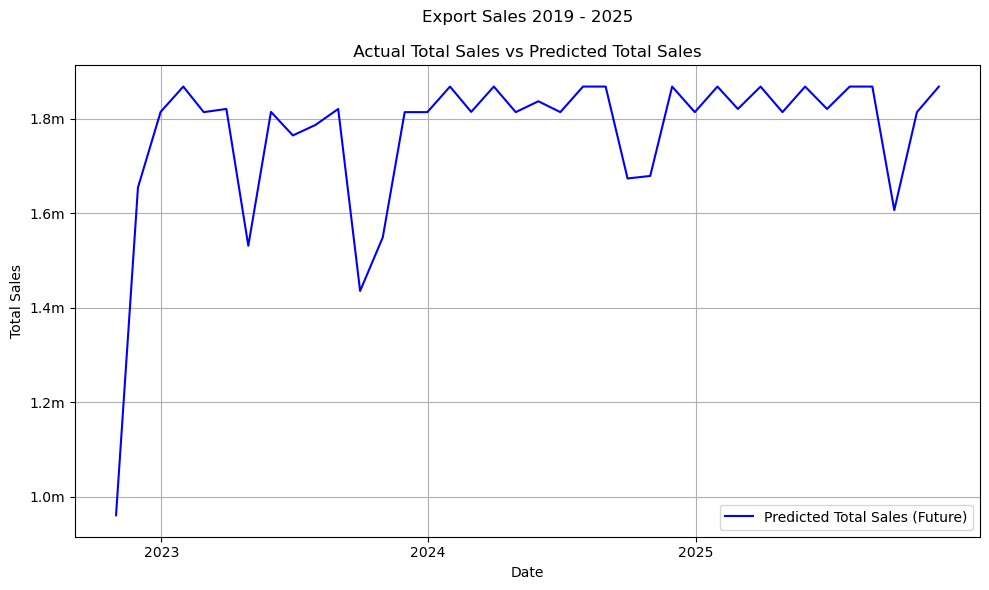

In [292]:
#Predicted Future Total Export Sales

import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter

# Sort the combined DataFrame by index (Date_Time)
predicted_total_sales_future_df.sort_index(inplace=True)

# Plotting the line chart for Predicted Total Sales Future
plt.figure(figsize=(10, 6))
plt.plot(predicted_total_sales_future_df.index, predicted_total_sales_future_df['Predicted_Total_Sales_Future'], label='Predicted Total Sales (Future)', color='blue')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Export Sales 2019 - 2025\n\n Actual Total Sales vs Predicted Total Sales ')
plt.legend(loc='best')
plt.grid(True)

# Set the x-axis ticks to only display the years 2023, 2024, and 2025
plt.xticks(ticks=[pd.Timestamp(f"{year}-01-01") for year in range(2023, 2026)], labels=[str(year) for year in range(2023, 2026)])

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.tight_layout()
plt.show()


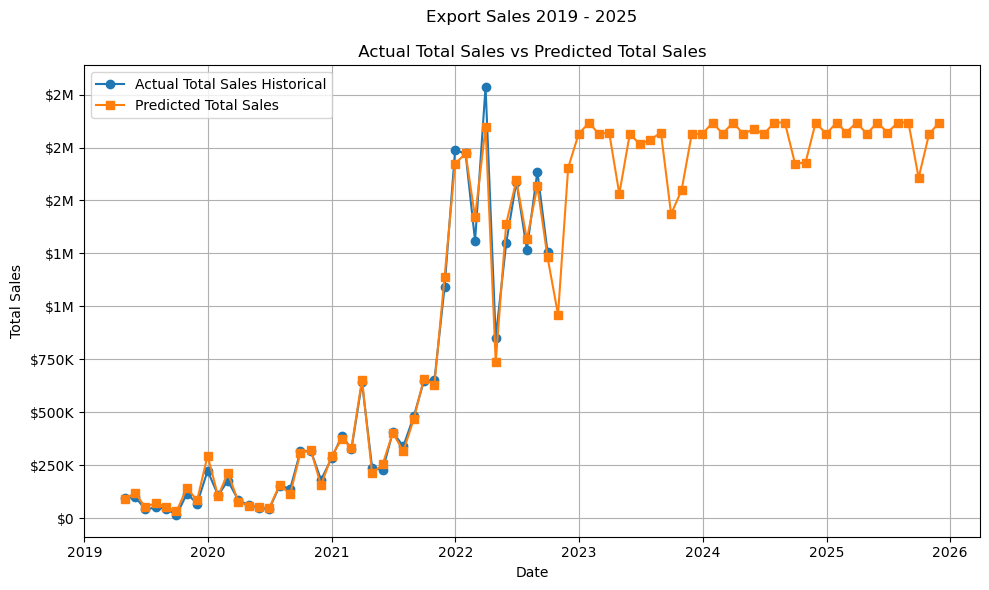

In [272]:
#Export Sales 2019 - 2025

# Create DataFrames for actual total sales historical, predicted total sales historical, and predicted total sales future
actual_total_sales_df = pd.DataFrame({
    'Actual_Total_Sales_Historical': rf_df_monthly_copy['Total_Sales']
})

predicted_total_sales_df = pd.DataFrame({
    'Predicted_Total_Sales': list(predicted_sales_historical) + list(predicted_sales_future)
}, index=rf_df_monthly.index.tolist() + forecast_df.index.tolist())

# Sort the combined DataFrame by index (Date_Time)
predicted_total_sales_df.sort_index(inplace=True)

# Plotting the line chart for Actual vs Predicted Total Sales Historical and Future
plt.figure(figsize=(10, 6))
plt.plot(actual_total_sales_df.index, actual_total_sales_df['Actual_Total_Sales_Historical'], label='Actual Total Sales Historical', marker='o')
plt.plot(predicted_total_sales_df.index, predicted_total_sales_df['Predicted_Total_Sales'], label='Predicted Total Sales', marker='s')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Export Sales 2019 - 2025\n\n Actual Total Sales vs Predicted Total Sales ')
plt.legend(loc='upper left')
plt.grid(True)

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.tight_layout()
plt.show()

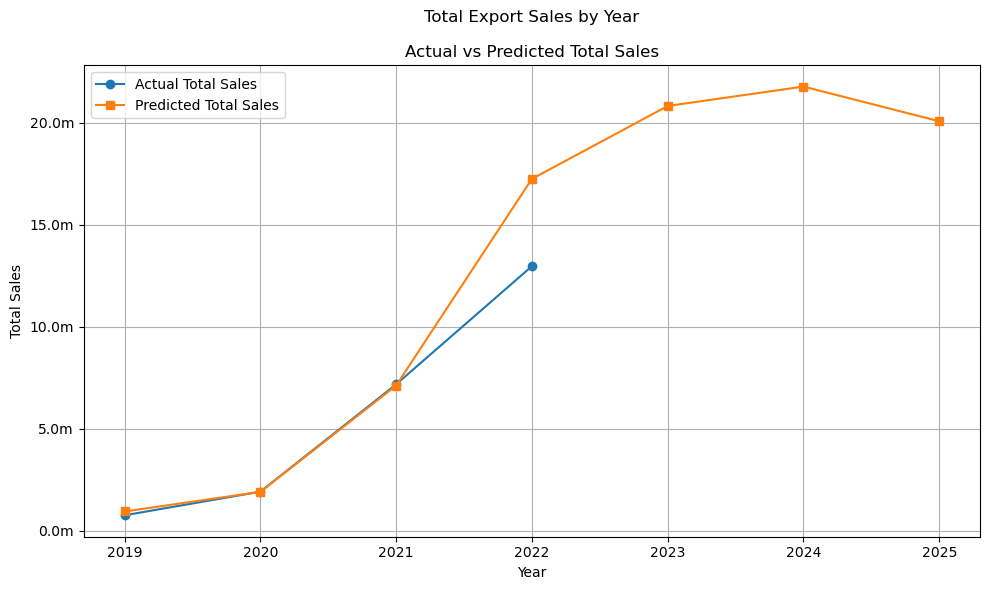

In [291]:
#Total Export Sales by Year

import matplotlib.ticker as ticker

# Calculate yearly totals for actual and predicted total sales
actual_yearly_totals = actual_total_sales_df.resample('Y').sum()
predicted_yearly_totals = predicted_total_sales_df.resample('Y').sum()

# Plotting the line chart for Actual vs Predicted Total Sales Yearly
plt.figure(figsize=(10, 6))
plt.plot(actual_yearly_totals.index.year, actual_yearly_totals['Actual_Total_Sales_Historical'], label='Actual Total Sales', marker='o')
plt.plot(predicted_yearly_totals.index.year, predicted_yearly_totals['Predicted_Total_Sales'], label='Predicted Total Sales', marker='s')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Export Sales by Year\n\nActual vs Predicted Total Sales')
plt.legend()
plt.grid(True)

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.tight_layout()
plt.show()

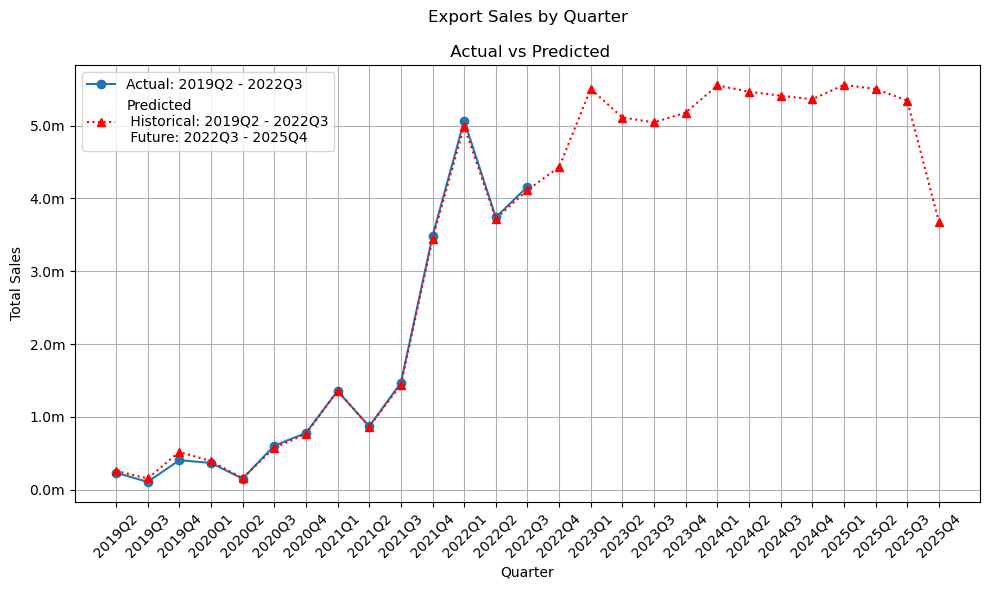

In [289]:
#Export Sales by Quarter

import matplotlib.ticker as ticker

# Extract quarter and year from the index
actual_total_sales_df['Quarter'] = actual_total_sales_df.index.to_period('Q').astype(str)
predicted_total_sales_historical_df['Quarter'] = predicted_total_sales_historical_df.index.to_period('Q').astype(str)
predicted_total_sales_future_df['Quarter'] = predicted_total_sales_future_df.index.to_period('Q').astype(str)

# Calculate the average sales for each quarter
total_actual_sales = actual_total_sales_df.groupby('Quarter')['Actual_Total_Sales_Historical'].sum()
total_predicted_historical_sales = predicted_total_sales_historical_df.groupby('Quarter')['Predicted_Total_Sales_Historical'].sum()
total_predicted_future_sales = predicted_total_sales_future_df.groupby('Quarter')['Predicted_Total_Sales_Future'].sum()

# Combine the predicted historical and future sales dataframes
combined_predicted_sales = pd.concat([total_predicted_historical_sales, total_predicted_future_sales])
combined_predicted_sales.sort_index(inplace=True)

# Plotting the line chart for Actual vs Predicted Total Sales Historical and Future
plt.figure(figsize=(10, 6))
plt.plot(total_actual_sales.index, total_actual_sales.values, label='Actual: 2019Q2 - 2022Q3 ', marker='o')
plt.plot(combined_predicted_sales.index, combined_predicted_sales.values, label='Predicted\n Historical: 2019Q2 - 2022Q3\n Future: 2022Q3 - 2025Q4', marker='^', linestyle=':', color='red')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.title('Export Sales by Quarter\n\n Actual vs Predicted')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_func))

plt.tight_layout()
plt.show()


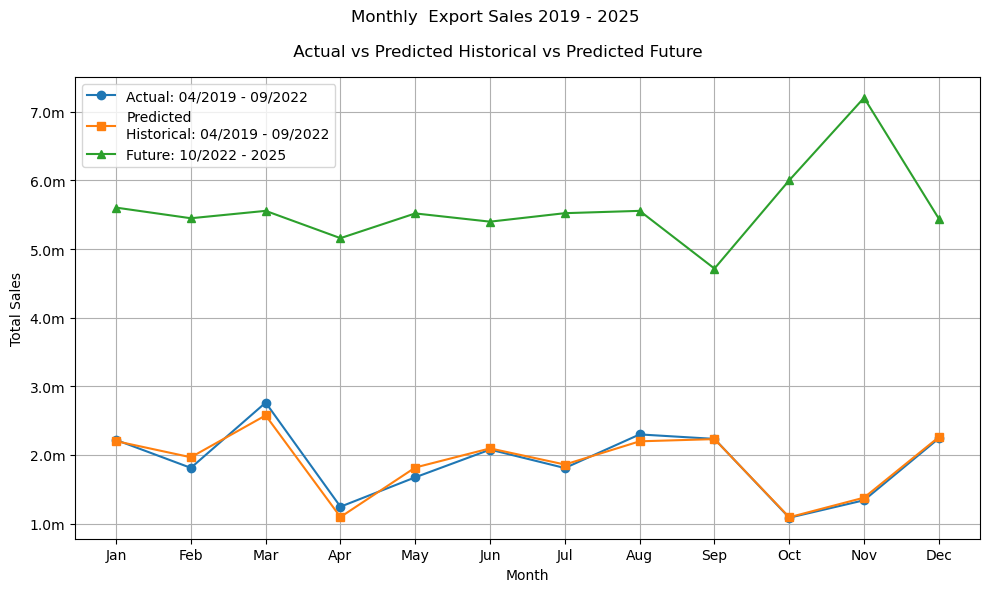

In [290]:
#Export Sales by Month
#Actual vs Predicted Historical vs Predicted Future

import matplotlib.ticker as ticker

# Extract month from the index
actual_total_sales_df['Month'] = actual_total_sales_df.index.month
predicted_total_sales_historical_df['Month'] = predicted_total_sales_historical_df.index.month
predicted_total_sales_future_df['Month'] = predicted_total_sales_future_df.index.month

# Calculate the average sales for each month
average_actual_sales = actual_total_sales_df.groupby('Month')['Actual_Total_Sales_Historical'].sum()
average_predicted_historical_sales = predicted_total_sales_historical_df.groupby('Month')['Predicted_Total_Sales_Historical'].sum()
average_predicted_future_sales = predicted_total_sales_future_df.groupby('Month')['Predicted_Total_Sales_Future'].sum()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the line chart for Actual vs Predicted Total Sales Historical and Future
ax.plot(average_actual_sales.index, average_actual_sales.values, label='Actual: 04/2019 - 09/2022', marker='o')
ax.plot(average_predicted_historical_sales.index, average_predicted_historical_sales.values, label='Predicted\nHistorical: 04/2019 - 09/2022', marker='s')
ax.plot(average_predicted_future_sales.index, average_predicted_future_sales.values, label='Future: 10/2022 - 2025', marker='^')

# Set x and y labels
ax.set_xlabel('Month')
ax.set_ylabel('Total Sales')

ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# Set the overall subplot title
fig.suptitle('Monthly  Export Sales 2019 - 2025\n\n Actual vs Predicted Historical vs Predicted Future', fontsize=12)
ax.legend()
ax.grid(True)

# Set x-axis ticks to month names
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.tight_layout()
plt.show()
